In [1]:
import uproot
import numpy
import vector
import matplotlib.pyplot as plt
import pickle

In [2]:
def initialize_vectors(E, px, py, pz):
    vector_list = []
    num_events = len(E)
    for event in range(num_events):
        vector_list.append(vector.obj(px=px[event], py=py[event], pz=pz[event], E=E[event]))
    return vector_list

In [3]:
def get_vectors(file):
    with uproot.open(file+":events") as file:
        mass=file["mass"].array()
        pid=file["pid"].array()
        px=file["px"].array()
        py=file["py"].array()
        pz=file["pz"].array()
        E=file["energy"].array()
        status=file["status"].array()

        antitopE = numpy.ravel(E[pid==-6])
        antitoppx = numpy.ravel(px[pid==-6])
        antitoppy = numpy.ravel(py[pid==-6])
        antitoppz = numpy.ravel(pz[pid==-6])

        topE = numpy.ravel(E[pid==6])
        toppx = numpy.ravel(px[pid==6])
        toppy = numpy.ravel(py[pid==6])
        toppz = numpy.ravel(pz[pid==6])

        mask1 = abs(pid)==1
        mask2 = abs(pid)==3
        mask3 = status>0
        mask = (mask1|mask2)&mask3
        downE = numpy.ravel(E[mask])
        downpx = numpy.ravel(px[mask])
        downpy = numpy.ravel(py[mask])
        downpz = numpy.ravel(pz[mask])

    top_vectors = initialize_vectors(topE, toppx, toppy, toppz)
    antitop_vectors = initialize_vectors(antitopE, antitoppx, antitoppy, antitoppz)
    down_vectors = initialize_vectors(downE, downpx, downpy, downpz)
    
    return top_vectors, antitop_vectors, down_vectors

In [4]:
def apply_boost(vec1, vec2, vec3=None):
    results=[]
    num_events=(len(vec1))
    for i in range(num_events):
        if vec3 is not None:
            boost=(vec2[i]+vec3[i])
        else: 
            boost=vec2[i]
        results.append(vec1[i].boostCM_of(boost))
    return results

In [5]:
top_vectors_L, antitop_vectors_L, down_vectors_L = get_vectors("hard_process_L_10k.root")

top_vectors_CM_L = apply_boost(top_vectors_L, top_vectors_L, antitop_vectors_L)
down_vectors_CM_L = apply_boost(down_vectors_L, top_vectors_L, antitop_vectors_L)
down_vectors_top_L = apply_boost(down_vectors_CM_L, top_vectors_CM_L, None)

In [6]:
top_vectors_R, antitop_vectors_R, down_vectors_R = get_vectors("hard_process_R_10k.root")

top_vectors_CM_R = apply_boost(top_vectors_R, top_vectors_R, antitop_vectors_R)
down_vectors_CM_R = apply_boost(down_vectors_R, top_vectors_R, antitop_vectors_R)
down_vectors_top_R = apply_boost(down_vectors_CM_R, top_vectors_CM_R, None)

In [7]:
cos_theta_L=[]
for i in range(len(top_vectors_CM_L)):
    cos_theta_L.append(top_vectors_CM_L[i].to_3D().unit()@down_vectors_top_L[i].to_3D().unit())

In [8]:
cos_theta_R=[]
for i in range(len(top_vectors_CM_R)):
    cos_theta_R.append(top_vectors_CM_R[i].to_3D().unit()@down_vectors_top_R[i].to_3D().unit())

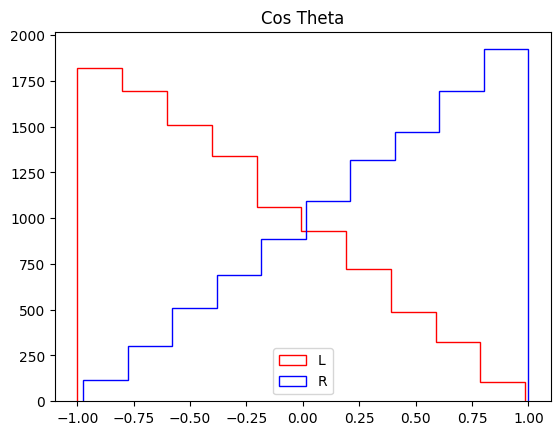

In [9]:
plt.title("Cos Theta")
plt.hist(cos_theta_L, histtype='step', color='r', label='L')
plt.hist(cos_theta_R, histtype='step', color='b', label='R')
plt.legend()
plt.show()

In [10]:
dataset_L=[]
for i in range(len(top_vectors_L)):
    dataset_L.append([
                     down_vectors_L[i].px, down_vectors_L[i].py, down_vectors_L[i].pz, down_vectors_L[i].E,
                     top_vectors_L[i].px, top_vectors_L[i].py, top_vectors_L[i].pz, top_vectors_L[i].E,
                     #antitop_vectors_L[i].px, antitop_vectors_L[i].py, antitop_vectors_L[i].pz, antitop_vectors_L[i].E,

                     ])
dataset_L=numpy.array(dataset_L)
labels_L=numpy.zeros((len(dataset_L),1))

In [11]:
dataset_R=[]
for i in range(len(top_vectors_R)):
    dataset_R.append([
                     down_vectors_R[i].px, down_vectors_R[i].py, down_vectors_R[i].pz, down_vectors_R[i].E,
                     top_vectors_R[i].px, top_vectors_R[i].py, top_vectors_R[i].pz, top_vectors_R[i].E,
                     #antitop_vectors_R[i].px, antitop_vectors_R[i].py, antitop_vectors_R[i].pz, antitop_vectors_R[i].E,
                     ])
dataset_R=numpy.array(dataset_R)
labels_R=numpy.ones((len(dataset_R),1))

In [12]:
dataset=numpy.concatenate([dataset_L, dataset_R], axis=0)
labels=numpy.concatenate([labels_L, labels_R], axis=0)

In [13]:
p=numpy.random.permutation(len(dataset))
dataset_shuffled=dataset[p]
labels_shuffled=labels[p]

In [14]:
total_num_events=len(labels_shuffled)
test_train_split = int(0.7*total_num_events)

dataset_train=dataset_shuffled[0:test_train_split]
labels_train=labels_shuffled[0:test_train_split]

dataset_test=dataset_shuffled[test_train_split:]
labels_test=labels_shuffled[test_train_split:]

In [15]:
with open("dataset_train.pkl", "wb") as f:
    pickle.dump((dataset_train, labels_train), f)
with open("dataset_test.pkl", "wb") as f:
    pickle.dump((dataset_test, labels_test), f)